# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.nn.utils.weight_norm as weight_norm

import random
# for Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

generator_path = 'weightNorm_gan_generator.pth'
discriminator_path = 'weightNorm_discriminator.pth'

Using device: cuda:0


# Loading CIFAR-10

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),  # Resize images to 64x64 for easier processing
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


# Generator

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            weight_norm(nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False)),
            nn.ReLU(True),
            # state size. 512 x 4 x 4
            weight_norm(nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. 256 x 8 x 8
            weight_norm(nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. 128 x 16 x 16
            weight_norm(nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)),
            nn.ReLU(True),
            # state size. 64 x 32 x 32
            weight_norm(nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False)),
            nn.Tanh()
            # state size. 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            weight_norm(nn.Conv2d(3, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 64 x 32 x 32
            weight_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 128 x 16 x 16
            weight_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 256 x 8 x 8
            weight_norm(nn.Conv2d(256, 512, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. 512 x 4 x 4
            weight_norm(nn.Conv2d(512, 1, 4, 1, 0, bias=False)),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Weights

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

# Optimizers (adam)

In [6]:
import torch.optim as optim

# Create the generator and discriminator instances
netG = Generator().apply(weights_init).to(device)

netD = Discriminator().apply(weights_init).to(device)

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

c:\Users\joshu\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\utils\weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


# Loss Function

In [7]:
criterion = torch.nn.BCELoss()

# Improvements

In [8]:
def flip_labels_for_generator(target_real):
    return 1 - target_real

# Custom function for noisy labels
def noisy_labels(labels, p_flip=0.05):
    # Flipping labels with probability p_flip
    flipped = labels.clone()
    select_to_flip = torch.rand(len(labels)) < p_flip
    flipped[select_to_flip] = 1 - flipped[select_to_flip]
    return flipped

# Custom function for smooth labels
def smooth_labels(labels, label_noise=0.1):
    # Adding some noise to the labels for smoothing
    noise = torch.rand(len(labels), device=labels.device) * label_noise
    smoothed = labels + noise
    smoothed = torch.clamp(smoothed, 0, 1)
    return smoothed


# Training Loop

In [9]:
# Number of training epochs
num_epochs = 100

# Labels for real and fake images with smoothing
real_label_sm = 0.99
fake_label_sm = 0.01

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Update discriminator with real images
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        # Smooth labels for real images
        label_real = torch.full((b_size,), real_label_sm, dtype=torch.float, device=device)  
        label_real_smooth = smooth_labels(label_real, label_noise=0.1)
        
        # Noisy labels for the discriminator
        noisy_label_real = noisy_labels(label_real_smooth, p_flip=0.05)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, noisy_label_real)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake image batch with netG
        noise = torch.randn(b_size, 100, 1, 1, device=device)  # Gaussian noise
        fake = netG(noise)
        label_fake = torch.full((b_size,), fake_label_sm, dtype=torch.float, device=device)
        
        # Smooth labels for fake images
        label_fake_smooth = smooth_labels(label_fake, label_noise=0.1)
        
        # Noisy labels for the discriminator
        noisy_label_fake = noisy_labels(label_fake_smooth, p_flip=0.05)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, noisy_label_fake)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update generator
        netG.zero_grad()
        
        # Flipped labels for generator training
        flipped_labels = flip_labels_for_generator(noisy_label_fake)
        
        output = netD(fake).view(-1)
        errG = criterion(output, flipped_labels)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        print(f'Epoch [{epoch+1}/{num_epochs}] Loss_D: {errD.item()}, Loss_G: {errG.item()}')
        
torch.save(netG.state_dict(), generator_path)
torch.save(netD.state_dict(), discriminator_path)
print(f"Models saved to {generator_path} and {discriminator_path}")


Epoch [1/100] Loss_D: 1.3879499435424805, Loss_G: 0.6931009292602539
Epoch [1/100] Loss_D: 1.3603346347808838, Loss_G: 0.6928240060806274
Epoch [1/100] Loss_D: 1.3285815715789795, Loss_G: 0.6917899250984192
Epoch [1/100] Loss_D: 1.2841463088989258, Loss_G: 0.6879856586456299
Epoch [1/100] Loss_D: 1.2192916870117188, Loss_G: 0.6754382848739624
Epoch [1/100] Loss_D: 1.1427446603775024, Loss_G: 0.6438517570495605
Epoch [1/100] Loss_D: 1.1217752695083618, Loss_G: 0.5821117162704468
Epoch [1/100] Loss_D: 1.2015101909637451, Loss_G: 0.5562777519226074
Epoch [1/100] Loss_D: 1.2499691247940063, Loss_G: 0.5647077560424805
Epoch [1/100] Loss_D: 1.258489966392517, Loss_G: 0.6244630217552185
Epoch [1/100] Loss_D: 1.1325241327285767, Loss_G: 0.6765244007110596
Epoch [1/100] Loss_D: 1.0699450969696045, Loss_G: 0.7223475575447083
Epoch [1/100] Loss_D: 1.0327086448669434, Loss_G: 0.7629939317703247
Epoch [1/100] Loss_D: 0.9678223133087158, Loss_G: 0.796680748462677
Epoch [1/100] Loss_D: 0.889663994312

# Generating Images

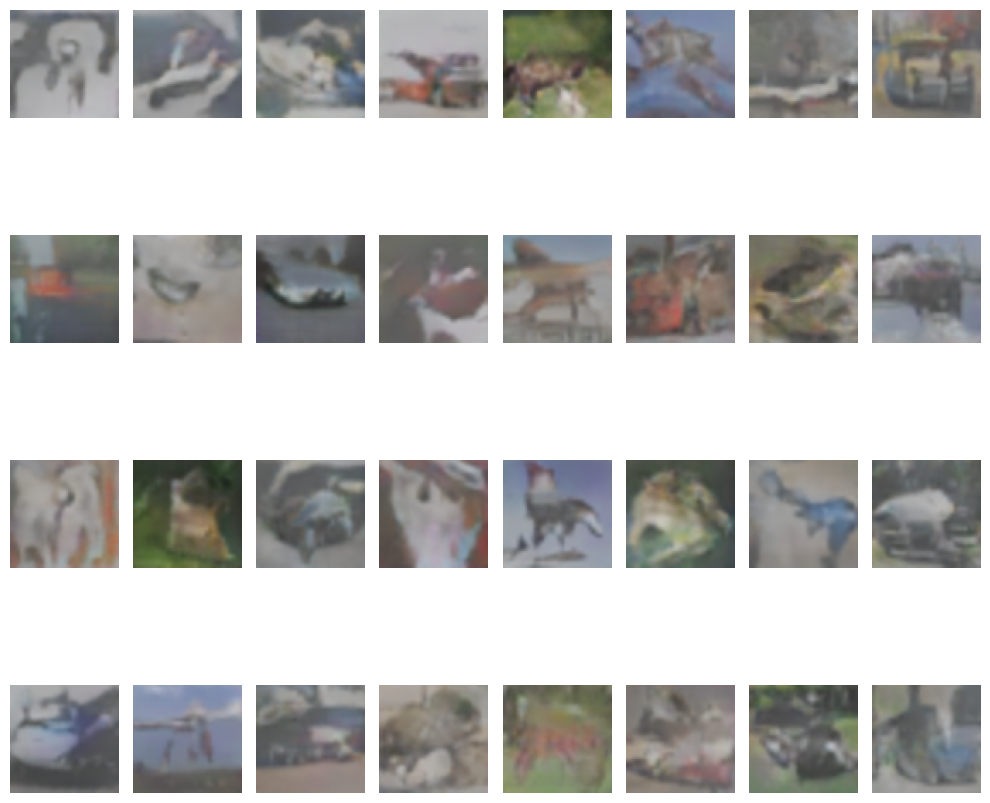

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize image data from [-1, 1] to [0, 1]
def denormalize(images):
    images = images / 2 + 0.5  # Convert images from range [-1,1] to [0,1]
    images = images.clamp(0, 1)
    images = images.detach().numpy()
    return images

# Generate batch of latent vectors
fixed_noise = torch.randn(64, 100, 1, 1, device=device)  # 64 is the batch size for generated images

# Generate fake image batch with netG
netG.eval()  # Set the generator to evaluation mode
with torch.no_grad():  # We don't need to track gradients
    fake_images = netG(fixed_noise).cpu()

# Convert images to numpy for visualization
fake_images = denormalize(fake_images)

# Plot the generated images
fig, axs = plt.subplots(4, 8, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(np.transpose(fake_images[i], (1, 2, 0)))  # Convert from Torch's CHW to Matplotlib's HWC
    ax.axis('off')
plt.tight_layout()
plt.show()

# Preloading

In [ ]:
Generator_saved = 
Descriminator_saved =

Generator_saved.load_state_dict(torch.load(PATH))

Descriminator_saved.load_state_dict(torch.load(PATH))





# Cosine Similiarity

In [24]:
import torch
import torchvision.models as models
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader



# Load a pre-trained ResNet model
resnet18 = models.resnet18(pretrained=True).to(device)
# Remove the fully connected layer for feature extraction
resnet18 = torch.nn.Sequential(*(list(resnet18.children())[:-1]))
resnet18.eval()

def extract_features(model, dataloader, num_samples=100):
    """Extracts features from the model up to num_samples images."""
    features = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # Check if the dataloader returns labels, if not, just use the data
            if len(data) == 2:
                inputs, _ = data
            else:
                inputs = data[0]  # Only data, no labels
                
            inputs = inputs.to(device)
            output = model(inputs)
            output = output.view(output.size(0), -1)
            features.append(output)
            if len(features) * dataloader.batch_size >= num_samples:
                break
    features = torch.cat(features, 0)
    features = features[:num_samples]
    return features

def compute_cosine_similarity(features1, features2):
    """Compute the cosine similarity between two sets of features."""
    # Normalize the feature vectors
    features1_norm = F.normalize(features1, p=2, dim=1)
    features2_norm = F.normalize(features2, p=2, dim=1)
    # Compute the cosine similarity
    similarity_matrix = torch.mm(features1_norm, features2_norm.t())
    return similarity_matrix

# Extract features from real images
real_features = extract_features(resnet18, train_loader, num_samples=100)

# Generate a set of fake images
fake_noise = torch.randn(100, 100, 1, 1, device=device)  # 100 samples
fake_images = netG(fake_noise).detach()
fake_loader = DataLoader(TensorDataset(fake_images), batch_size=128, shuffle=False)

# Extract features from fake images
fake_features = extract_features(resnet18, fake_loader)

# Compute the cosine similarity
similarity = compute_cosine_similarity(fake_features, real_features)
average_similarity = similarity.mean().item()

print(f'Average Cosine Similarity: {average_similarity}')


Average Cosine Similarity: 0.3951643705368042
